In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from gensim.models import Word2Vec



### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('https://raw.githubusercontent.com/joseluisdiaz/procesamiento_lenguaje_natural-tp/refs/heads/main/data/songs_dataset/radiohead.txt', sep='/n', header=None, engine='python')

print(f"Cantidad de documentos (versos) de Radiohead: {df.shape[0]}")

df.head()


Cantidad de documentos (versos) de Radiohead: 2343


,0
0,"Come on, come on"
1,You think you drive me crazy
2,"Come on, come on"
3,You and whose army?
4,You and your cronies


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2343


In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

print(f"Se cargaron {len(sentence_tokens)} versos de Radiohead.")

Se cargaron 2343 versos de Radiohead.


In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['come', 'on', 'come', 'on'], ['you', 'think', 'you', 'drive', 'me', 'crazy']]

### 1 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=3,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=4,       # Aumentamos un poco la ventana para capturar contexto más abstracto
                     vector_size=200,
                     negative=20,
                     workers=1,
                     sg=1)           #  1:skipgram

In [ ]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 2343


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 616


In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=35,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 128518.65625
Loss after epoch 1: 63696.578125
Loss after epoch 2: 61164.96875
Loss after epoch 3: 59848.859375
Loss after epoch 4: 58187.5
Loss after epoch 5: 60015.5
Loss after epoch 6: 57321.34375
Loss after epoch 7: 57202.59375
Loss after epoch 8: 55028.125
Loss after epoch 9: 53347.6875
Loss after epoch 10: 52411.4375
Loss after epoch 11: 51184.5625
Loss after epoch 12: 50021.1875
Loss after epoch 13: 50087.0
Loss after epoch 14: 47269.0625
Loss after epoch 15: 46687.9375
Loss after epoch 16: 45853.0
Loss after epoch 17: 43738.125
Loss after epoch 18: 40753.625
Loss after epoch 19: 40040.625
Loss after epoch 20: 38382.125
Loss after epoch 21: 38474.625
Loss after epoch 22: 37697.25
Loss after epoch 23: 37442.625
Loss after epoch 24: 37068.0
Loss after epoch 25: 36886.375
Loss after epoch 26: 36267.125
Loss after epoch 27: 36237.0
Loss after epoch 28: 35984.375
Loss after epoch 29: 35074.75
Loss after epoch 30: 35923.625
Loss after epoch 31: 34940.25
Loss after e

(238253, 413105)


### 2 - Términos de interés

In [ ]:
# "high" por high and dry

w2v_model.wv.most_similar(positive=["high"], topn=10)

[('dry', 0.9817825555801392),
 ('leave', 0.9577761292457581),
 ('through', 0.8877123594284058),
 ('arms', 0.8806434273719788),
 ('blow', 0.8565056920051575),
 ('gather', 0.843209981918335),
 ("don't", 0.84080970287323),
 ('ow', 0.8314539194107056),
 ('hurt', 0.8246138691902161),
 ('reach', 0.8187612295150757)]

Alguna interpretación:
- dry (0.98): Es la palabra más cercana con diferencia. Esto es lógico porque en la canción High and Dry, la frase "high and dry" se repite constantemente. El modelo aprendió que cuando aparece "high", "dry" casi seguro está al lado.
- leave (0.95): Fíjate en la letra: "Don't leave me high, don't leave me dry". El modelo capturó esa relación sintáctica directa.


In [ ]:
w2v_model.wv.most_similar(positive=["fake"], topn=10)

[('plastic', 0.968227207660675),
 ('leaves', 0.9511414766311646),
 ('spectre', 0.9486548900604248),
 ('pieces', 0.9440883994102478),
 ('walking', 0.943368673324585),
 ('burns', 0.9418102502822876),
 ('karma', 0.9378960132598877),
 ('lung', 0.937308669090271),
 ('ocean', 0.9344267845153809),
 ('hand', 0.9336872100830078)]

Aunque la canción más famosa que contiene esta palabra es Fake Plastic Trees, el modelo agrupa fake fuertemente con plastic (0.96) y no con trees. Esto ocurre porque en la letra cantada, la colocación "fake plastic" aparece múltiples veces ("fake plastic earth", "fake plastic love"), pero la palabra "trees" nunca les sigue inmediatamente. Es un excelente ejemplo de cómo el modelo aprende estrictamente del texto procesado y no del conocimiento general o títulos.

In [ ]:
w2v_model.wv.most_similar(positive=["karma"], topn=10)


[('witch', 0.983668863773346),
 ('ocean', 0.9799566268920898),
 ('tumbling', 0.9791244864463806),
 ('beyond', 0.9777624011039734),
 ('police', 0.9759169220924377),
 ('lung', 0.9759106040000916),
 ('leaves', 0.9735955595970154),
 ('self', 0.971339225769043),
 ('every', 0.9706147313117981),
 ("nothin'", 0.9689868092536926)]

Para karma, el modelo encuentra correctamente a police (0.97), recuperando el título de la canción. Pero curiosamente, palabras como witch o lung aparecen igual de cerca. Esto sucede porque el modelo está agrupando "palabras clave de Radiohead" (títulos o letras muy específicas) en un mismo cluster denso, separándolas del resto del vocabulario común. Es un efecto claro de usar vectores grandes en un dataset pequeño.

In [ ]:
w2v_model.wv.most_similar(positive=["creep"], topn=10)


[('weirdo', 0.9961198568344116),
 ('ready', 0.9302974939346313),
 ('tingling', 0.9157785773277283),
 ('superhero', 0.8477675914764404),
 ('kid', 0.8241105675697327),
 ('but', 0.8063837289810181),
 ('stuffed', 0.7921950221061707),
 ('roll', 0.7836613059043884),
 ("i'm", 0.7832690477371216),
 ('sorry', 0.7746464014053345)]

El término 'creep', el modelo reveló una capacidad sorprendente, encontró su par semántico evidente ('weirdo' con 0.99), el modelo agrupó palabras que cumplen la función de atributo del sujeto en primera persona.

In [ ]:
w2v_model.wv.most_similar(positive=["alive"], topn=10)


[('totally', 0.827039897441864),
 ('fish', 0.8035797476768494),
 ('will', 0.7905845046043396),
 ('keeps', 0.7810829877853394),
 ('against', 0.7665865421295166),
 ('eat', 0.7408241033554077),
 ('first', 0.733736515045166),
 ('big', 0.7313074469566345),
 ('children', 0.7219460010528564),
 ('nerve', 0.7067044973373413)]

El término `alive` funciona como un nexo, conecta algunas canciones distintas. El modelo encontró las canciones Bodysnatchers ('totally'), Where I End and You Begin ('will', 'eat') e Idioteque ('first', 'children').

- "I'm alive, totally alive" (en Bodysnatchers).
- "I will eat you alive / I will eat you alive" (se repite muchas veces al final de la canción).
- "Here I'm alive, everything all of the time... the first of the children" (en Idioteque).
- "eat you alive" / The big fish eat the little ones".

### 3 - Visualizar agrupación de vectores

### Consigna del desafío 2

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado**

Recuerden que su notebook de entrega debe poder correrse de inicio a fin sin la aparición de errores.

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
- Elegir términos de interés y buscar términos más similares y menos similares.
- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)\

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

palabras_interes = [
    'rain', 'moon', 'stars',
    "don't", 'no', 'won\'t',
    'eyes', 'head', 'face',
    'karma', 'police',
    'high', 'dry',
    'fake', 'plastic'
]

# 2. Preparamos los datos
# Tomamos las top 200 palabras para que el gráfico tenga contexto, pero no sea un caos
MAX_WORDS = 400
vocab = w2v_model.wv.index_to_key[:MAX_WORDS]
vectors = np.asarray([w2v_model.wv[word] for word in vocab])

# 3. Reducción a 2D con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10) # perplexity bajo ayuda con pocos datos
vectors_2d = tsne.fit_transform(vectors)

# 4. Crear DataFrame para Plotly
df_plot = pd.DataFrame(vectors_2d, columns=['x', 'y'])
df_plot['word'] = vocab
# Marcamos las palabras de interés con un color distinto
df_plot['color'] = df_plot['word'].apply(lambda x: 'Destacada' if x in palabras_interes else 'Normal')

# 5. Graficar
fig = px.scatter(df_plot, x='x', y='y', text='word', color='color',
                 title="Mapa Semántico de Radiohead (t-SNE)",
                 color_discrete_map={'Destacada': 'red', 'Normal': 'blue'},
                 opacity=0.8)

fig.update_traces(textposition='top center', marker_size=8)
fig.layout.showlegend = False
fig.show(renderer="colab")

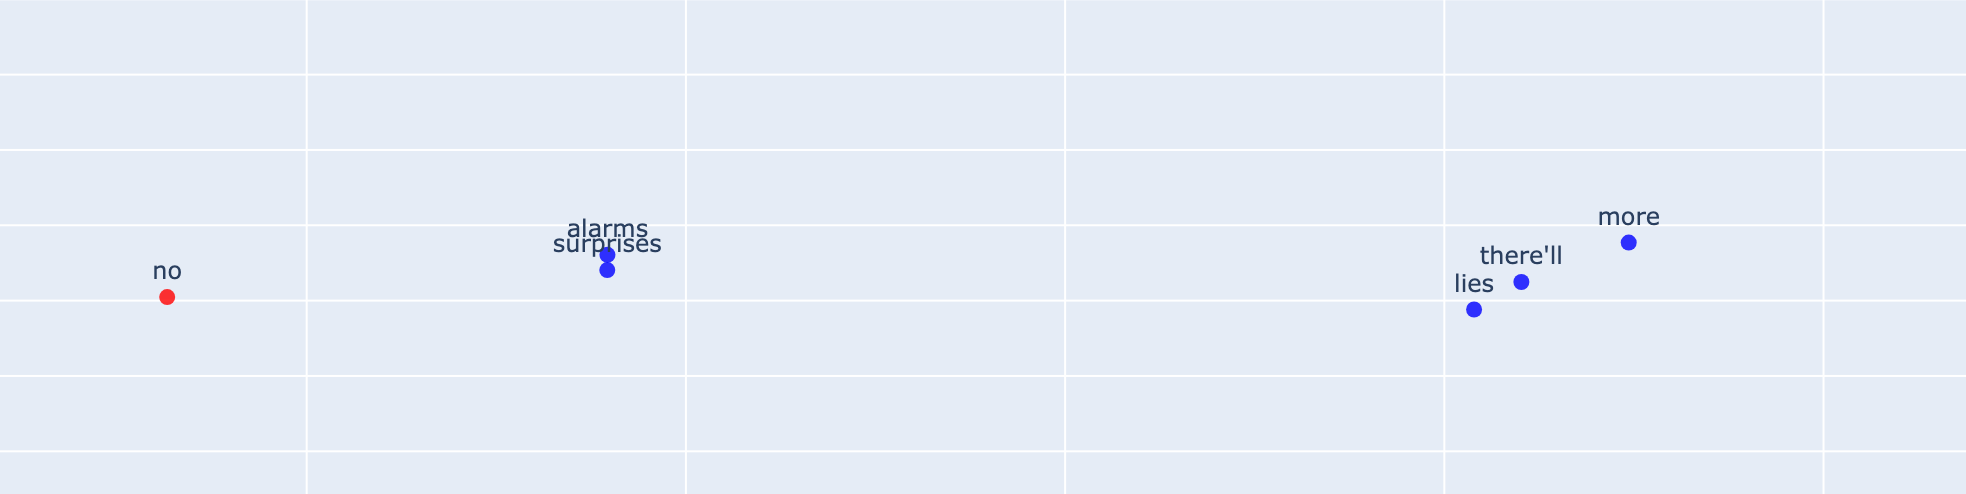

"No alarms and no surprises" se repite un en el estribillo de "no surprises"

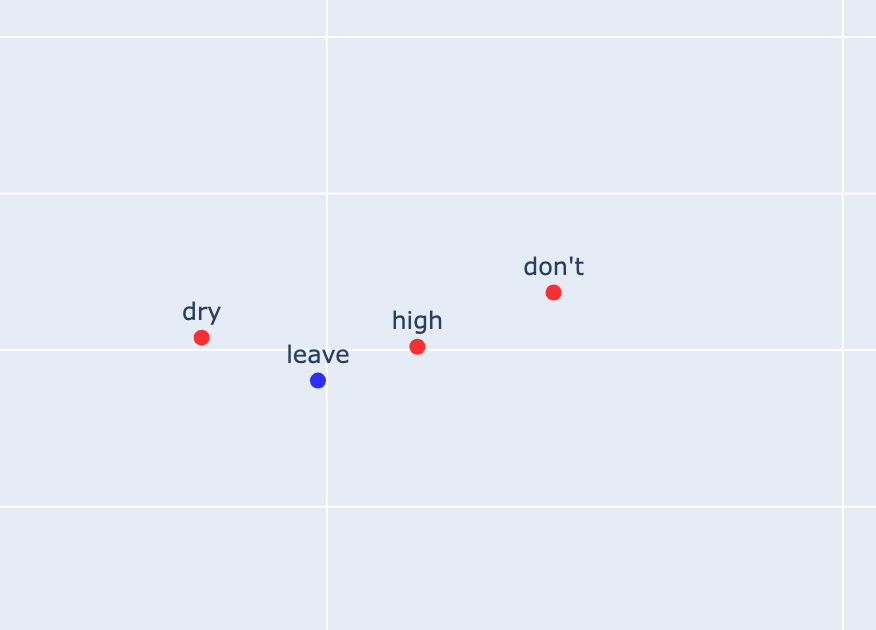

"don't leave me dry, don't leave me high" Se repite una cantidad de veces en High and Dry.

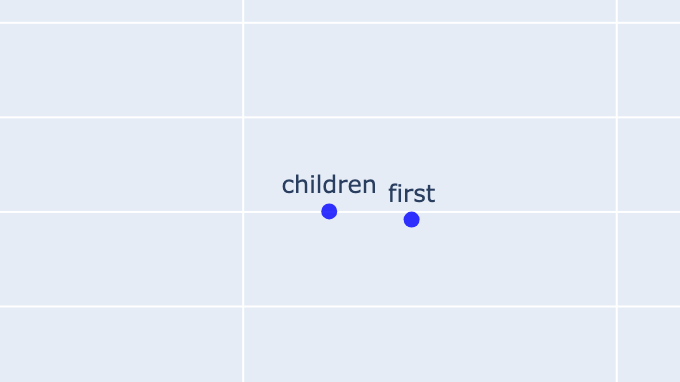

En "Idioteque" se repite "The first of the children" en el estribillo.